In [1]:
import warnings
warnings.filterwarnings("ignore")

from utils import dataset, load_bow
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
import os
import numpy as np
from math import e
from scipy.stats import stats
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as pyp
import matplotlib as mpl
%matplotlib inline


In [2]:
w = 12

In [3]:
col = [
    'Publication Type', \
    'Venue', \
    'Author Full Names', \
    'Article Title', \
    'Abstract', \
    'Publication Date', \
    'Publication Year']

venues = dataset()[col]
venues = venues.dropna(subset=['Abstract'])
venues['Abstract Lemmatized'] = load_bow('25_venues')
venues = venues.dropna(subset=['Publication Date'])
venues['Date'] = (venues['Publication Date']+'-'+venues['Publication Year']).apply(lambda x: datetime.strptime(x, '%b-%Y'))
venues = venues.sort_values(by='Date')
venues.index = range(len(venues))

df = pd.read_csv(f'./KLD/distributions_{w}.csv')
venues['LDA Distribution'] = df['LDA Distribution']

for c in [co for co in df.columns[-3:]]:
    venues[c] = df[c]

In [4]:
# for kld in os.listdir('./KLD'):
#     df = pd.read_csv('./KLD/'+kld)
#     for c in [co for co in df.columns if co[-1:] == kld[-5]]:
#         venues[c] = df[c]*np.log2(e)

In [5]:
# matplotlib globals
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['font.family'] = 'serif'

In [6]:
centininch = 2.54
inchincent = .3937

def centtoinch(cents):
    return .3937*cents

def inchtocent(inches):
    return 2.54*inches

In [7]:
venues

,Publication Type,Venue,Author Full Names,Article Title,Abstract,Publication Date,Publication Year,Abstract Lemmatized,Date,LDA Distribution,Novelty_12,Transience_12,Resonance_12
0,J,IEEE-TPAMI,"SCHONFELD, D; GOUTSIAS, J",OPTIMAL MORPHOLOGICAL PATTERN RESTORATION FROM...,A theoretical analysis of morphological filter...,Jan,1991,"[theoretical, analysis, morphological, filter,...",1991-01-01,"[(0, 0.037457425), (1, 0.0004891087), (2, 0.00...",NaN,7.191774,NaN
1,J,IEEE-TPAMI,"AYACHE, N; LUSTMAN, F",TRINOCULAR STEREO VISION FOR ROBOTICS,We present an original approach for building a...,Jan,1991,"[present, original, approach, build, dimension...",1991-01-01,"[(0, 0.0017579969), (1, 0.0015569901), (2, 0.0...",NaN,7.973034,NaN
2,J,IEEE-TPAMI,"BENGTSSON, A; EKLUNDH, JO",SHAPE REPRESENTATION BY MULTISCALE CONTOUR APP...,We present an approach for deriving qualitativ...,Jan,1991,"[present, approach, derive, qualitative, descr...",1991-01-01,"[(0, 0.062920325), (1, 0.00091733685), (2, 0.0...",NaN,6.745671,NaN
3,J,IEEE-TPAMI,"WOLFE, WJ; MATHIS, D; SKLAIR, CW; MAGEE, M",THE PERSPECTIVE VIEW OF 3 POINTS,In this paper we focus on the perspective view...,Jan,1991,"[paper, focus, perspective, view, noncollinear...",1991-01-01,"[(0, 0.0014872433), (1, 0.0013171942), (2, 0.0...",NaN,7.188360,NaN
4,J,IEEE-TPAMI,"WUESCHER, DM; BOYER, KL",ROBUST CONTOUR DECOMPOSITION USING A CONSTANT ...,In many computer vision paradigms it is necess...,Jan,1991,"[many, computer_vision, paradigm, necessary, d...",1991-01-01,"[(0, 0.0006670464), (1, 0.000590777), (2, 0.00...",NaN,6.373627,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161880,J,ESA,"Toochaei, Masoomeh Rashidpoor; Moeini, Farzad",Evaluating the performance of ensemble classif...,Stock market prediction is considered as an im...,Mar,2023,"[stock_market, prediction, consider, important...",2023-03-01,"[(0, 0.00026385064), (1, 0.022927916), (2, 0.0...",8.770067,NaN,NaN
161881,J,ESA,"Cabitza, Federico; Campagner, Andrea; Malgieri...",Quod erat demonstrandum?- Towards a typology o...,"In this paper, we present a fundamental framew...",Mar,2023,"[paper, present, fundamental, framework, defin...",2023-03-01,"[(0, 0.00092072686), (1, 0.0008154519), (2, 0....",8.229688,NaN,NaN
161882,J,ESA,"Chung, Doohee; Yun, Jinseop; Lee, Jeha; Jeon, ...",Predictive model of employee attrition based o...,Since human resource is the most important res...,Apr,2023,"[human, resource, most, important, resource, c...",2023-04-01,"[(0, 0.0006689712), (1, 0.00059248204), (2, 0....",7.542736,NaN,NaN
161883,J,ESA,"de Castro, Giulia Zanon; Guerra, Rubia Reis; G...",Automatic translation of sign language with mu...,Sign languages play an essential role in the c...,Apr,2023,"[language, play, essential, role, cognitive, s...",2023-04-01,"[(0, 0.0003868411), (1, 0.00034261023), (2, 0....",7.115032,NaN,NaN


In [8]:
reg = venues[[f'Novelty_{w}', f'Transience_{w}', f'Resonance_{w}']]
reg = reg.dropna(subset=[f'Novelty_{w}',f'Resonance_{w}'])
NTR_df = reg[[f'Novelty_{w}', f'Transience_{w}', f'Resonance_{w}']]

In [9]:
def plot_quants_2Dhist(quants, NTR_df, ax, xbins, ybins, make_cbar=True,
                       cbar_axis=False, cbar_orientation='vertical', colorvmax=None):

    q0 = NTR_df[quants[0]]
    q1 = NTR_df[quants[1]]
    
    q0bins = xbins
    q1bins = ybins
    
    H, xedges, yedges = np.histogram2d(q0,
                                       q1,
                                       bins=[q0bins, q1bins])

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)

    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value
    
    # Plot 2D histogram using pcolor
    if colorvmax:
        usemax = colorvmax
    else:
        usemax = H.max()
    pcolm = ax.pcolormesh(xedges,yedges,Hmasked, norm=mpl.colors.LogNorm(vmin=1, vmax=usemax))
    
    if make_cbar:
        if cbar_axis:
            cbar = fig.colorbar(pcolm, cax=cbar_axis, orientation=cbar_orientation)  
        else:
            cbar = fig.colorbar(pcolm, ax=ax, orientation=cbar_orientation)
        cbar.ax.set_ylabel('counts')
    
    ax.set_xlabel(quants[0])
    ax.set_ylabel(quants[1])
    
    if make_cbar:
        return H, cbar
    else:
        return H

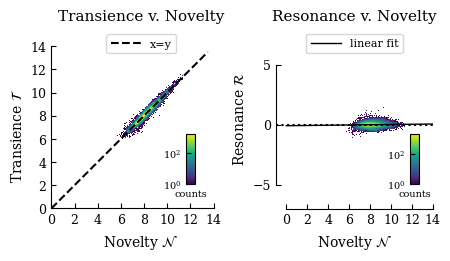

In [10]:
figsize = (centtoinch(11.4), 2.5)

fig = pyp.figure(figsize=figsize)

# Uncomment to see figure extent.
#ax = fig.add_axes([0., 0., 1., 1.])

## Plot Transience v. Novelty

ax = fig.add_axes([0.1, 0.19, 0.4, 0.72])

cbaxes = fig.add_axes([0.4, 0.29, 0.02, 0.2])

quants = [f'Novelty_{w}', f'Transience_{w}']

xbins = np.linspace(0, 14, 200)
ybins = np.linspace(0, 14, 200)

H, cbar = plot_quants_2Dhist(quants, NTR_df, ax, xbins, ybins,
                             make_cbar=True, cbar_axis=cbaxes, cbar_orientation='vertical')
cbar.ax.set_ylabel('')
cbar.ax.set_xlabel('counts', fontsize=7)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.tick_params(labelsize=7)

### Identity (x=y) line
ax.plot([0, 13.5], [0, 13.5], 'k--', linewidth=1.5)

ax.legend([mpl.lines.Line2D([0], [0], color='k', linewidth=1.5, linestyle='--')],
          ['x=y'],
          loc='upper center', fontsize=8, ncol=2, handlelength=2.7)

ax.set_ylabel('Transience $\mathcal{T}$         ')
ax.set_xlabel('Novelty $\mathcal{N}$')

ax.set_title('Transience v. Novelty')

ax.set_aspect('equal')

### Hide the right and top spines.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
### Show ticks only on the left and bottom spines.
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Limit spine range
ax.spines['left'].set_bounds( 0, 14)
ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 14])
ax.spines['bottom'].set_bounds( 0, 14)
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])

ax.set_ylim(0, 15.5)
ax.set_xlim(0, 15.5)

## Plot Reson v. Novelty

ax = fig.add_axes([0.6, 0.19, 0.35, 0.72])

cbaxes = fig.add_axes([0.9, 0.29, 0.02, 0.2])

quants = [f'Novelty_{w}', f'Resonance_{w}']

xbins = np.linspace(0, 15, 200)
ybins = np.linspace(-7, 8, 200)

H, cbar = plot_quants_2Dhist(quants, NTR_df, ax, xbins, ybins,
                             make_cbar=True, cbar_axis=cbaxes, cbar_orientation='vertical')
cbar.ax.set_ylabel('')
cbar.ax.set_xlabel('counts', fontsize=7)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.tick_params(labelsize=7)

ax.axhline(color='k', linewidth=1.5, linestyle=':')

# plot the linear regression line ressonance ~ novelty
slope, intercept, r_value, p_value, std_err = stats.linregress(NTR_df[f'Novelty_{w}'], NTR_df[f'Resonance_{w}'])
ax.plot([0, 14], [intercept, 14*slope+intercept], '-', linewidth=1, color='black')

ax.legend([mpl.lines.Line2D([0], [0], color='k', linewidth=1, linestyle='-')],
          ['linear fit'],
          loc='upper center', fontsize=8, ncol=2, handlelength=2.7)


ax.set_xlim(-1, 14)
ax.set_ylim(-7, 8)

### Hide the right and top spines.
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
### Show ticks only on the left and bottom spines.
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Limit spine range
ax.spines['left'].set_bounds( -5, 5)
ax.set_yticks([-5, 0, 5])
ax.spines['bottom'].set_bounds( 0, 14)
ax.set_xticks([ 0, 2, 4, 6, 8, 10, 12, 14])

ax.set_ylabel('Resonance $\mathcal{R}}$')
ax.set_xlabel('Novelty $\mathcal{N}$')

_ = ax.set_title('Resonance v. Novelty')


# w Selection

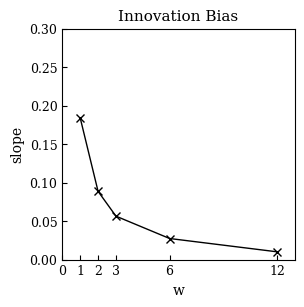

In [11]:
g = []
for i in [doc for doc in os.listdir('KLD') if doc[13]!='2']:
    w = int(i.split('_')[1].split('.')[0])
    reg = pd.read_csv('./KLD/'+i)
    reg = reg.dropna(subset=[f'Novelty_{w}',f'Resonance_{w}'])
    X = reg[f'Novelty_{w}']
    y = reg[f'Resonance_{w}']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    g.append([w, model.params[1], model.pvalues[1]])

g = pd.DataFrame(g, columns=['w', 'slope', 'pval'])
g = g.sort_values(by='w')

# plot the column 'w' in g against the column 'slope'
fig, ax = pyp.subplots(figsize=(3, 3))
ax.plot(g['w'], g['slope'], 'x-', color='black', linewidth=1)
ax.set_xlabel('w')
ax.set_ylabel('slope')
ax.set_title('Innovation Bias')
ax.set_ylim(0, 0.3)
ax.set_xlim(0, 13)
ax.set_xticks([0, 1, 2, 3, 6, 12])
pyp.show()
    

In [12]:
fix_dict = {
    'ABUALIGAH, LAITH': 'ABUALIGAH, LAITH MOHAMMAD',
    'ADAMS, RYAN P.': 'ADAMS, RYAN',
    'AGIRRE, E': 'AGIRRE, ENEKO',
    'AGIRRE, E.': 'AGIRRE, ENEKO',
    'AHUJA, N': 'AHUJA, NARENDRA',
    'AKRAM, MUHAMMAD': 'AKRAM, M. USMAN',
    'ALHAJJ, R': 'ALHAJJ, REDA',
    'ALIMI, A. M.': 'ALIMI, ADEL M.',
    'ALOIMONOS, Y': 'ALOIMONOS, YIANNIS',
    'ALSAADI, FUAD': 'ALSAADI, FUAD E.',
    'ALSAEDI, A.': 'ALSAEDI, AHMED',
    'AMARI, S': 'AMARI, SHUN-ICHI',
    'AMARI, SI': 'AMARI, SHUN-ICHI',
    'ARIK, S': 'ARIK, SABRI',
    'ASTROM, K': 'ASTROM, KALLE',
    'AVCI, E.': 'AVCI, ENGIN',
    'AVIDAN, S': 'AVIDAN, SHAI',
    'BACH, F.': 'BACH, FRANCIS R.',
    'BACH, FR': 'BACH, FRANCIS R.',
    'BACH, FRANCIS': 'BACH, FRANCIS R.',
    'BAESENS, B': 'BAESENS, BART',
    'BAGNELL, J. ANDREW': 'BAGNELL, JAMES ANDREW',
    'BAJO, J.': 'BAJO, JAVIER',
    'BALCAN, MARIA FLORINA': 'BALCAN, MARIA-FLORINA',
    'BALDWIN, T': 'BALDWIN, TIMOTHY',
    'BARANIUK, RICHARD': 'BARANIUK, RICHARD G.',
    'BARTLETT, P': 'BARTLETT, PETER L.',
    'BARTLETT, PETER': 'BARTLETT, PETER L.',
    'BARTLETT, PL': 'BARTLETT, PETER L.',
    'BARTOLI, A.': 'BARTOLI, ADRIEN',
    'BARTOLI, A': 'BARTOLI, ADRIEN',
    'BARZILAY, R': 'BARZILAY, REGINA',
    'BASRI, R': 'BASRI, RONEN',
    'BELLEMARE, MARC': 'BELLEMARE, MARC G.',
    'BELONGIE, S': 'BELONGIE, SERGE',
    'BENGIO, S': 'BENGIO, SAMY',
    'BENGIO, Y': 'BENGIO, YOSHUA',
    'BENNAMOUN, M': 'BENNAMOUN, MOHAMED',
    'BENNAMOUN, M.': 'BENNAMOUN, MOHAMED',
    'BERG, AC': 'BERG, ALEXANDER C.',
    'BERNHARD SCHÃ–LKOPF': 'BERNHARD SCHOLKOPF',
    'BERNHARD SCHOELKOPF': 'BERNHARD SCHOLKOPF',
    'BEZDEK, JC': 'BEZDEK, JAMES C.',
    'BHATTACHARYYA, C': 'BHATTACHARYYA, CHIRANJIB',
    'BI, JB': 'BI, JINBO',
    'BILMES, J': 'BILMES, JEFFREY A.',
    'BILMES, JEFF': 'BILMES, JEFFREY A.',
    'BILMES, JEFF A.': 'BILMES, JEFFREY A.',
    'BILMES, JEFFERY A.': 'BILMES, JEFFREY A.',
    'BISCHOF, H': 'BISCHOF, HORST',
    'BLACK, MICHAEL': 'BLACK, MICHAEL J.',
    'BLACK, MJ': 'BLACK, MICHAEL J.',
    'BLEI, DAVID': 'BLEI, DAVID M.',
    'BLEI, DM': 'BLEI, DAVID M.',
    'BOUGUILA, N': 'BOUGUILA, NIZAR',
    'BOULT, T. E.': 'BOULT, TERRANCE E.',
    'BOULT, TE': 'BOULT, TERRANCE E.',
    'BOULT, TERRANCE': 'BOULT, TERRANCE E.',
    'BOUTILIER, C': 'BOUTILIER, CRAIG',
    'BOYER, E': 'BOYER, EDMOND',
    'BOYKOV, Y': 'BOYKOV, YURI',
    'BREMOND, F': 'BREMOND, FRANCOIS',
    'BRONSTEIN, MICHAEL': 'BRONSTEIN, MICHAEL M.',
    'BROWN, MS': 'BROWN, MICHAEL S.',
    'BROX, T': 'BROX, THOMAS',
    'BU, JJ': 'BU, JIAJUN',
    'BUHMANN, JM': 'BUHMANN, JOACHIM M.',
    'BUSTINCE, H.': 'BUSTINCE, HUMBERTO',
    'CAI, RUI-CHU': 'CAI, RUICHU',
    'CAO, WM': 'CAO, WENMING',
    'CAPUTO, B': 'CAPUTO, BARBARA',
    'CARBONELL, JAIME': 'CARBONELL, JAIME G.',
    'CARDIE, C': 'CARDIE, CLAIRE',
    'CARIN, L': 'CARIN, LAWRENCE',
    'CARNEIRO, G': 'CARNEIRO, GUSTAVO',
    'CASTILLO, O': 'CASTILLO, OSCAR',
    'CASTILLO, O.': 'CASTILLO, OSCAR',
    'CHAI, TY': 'CHAI, TIANYOU',
    'CHAN, ANTONI': 'CHAN, ANTONI B.',
    'CHAN, CW': 'CHAN, CHRISTINE W.',
    'CHAN, F. T. S.': 'CHAN, FELIX T. S.',
    'CHAN, FTS': 'CHAN, FELIX T. S.',
    'CHANG, P. C.': 'CHANG, PEI-CHANN',
    'CHANG, PC': 'CHANG, PEI-CHANN',
    'CHATZIS, SOTIRIOS': 'CHATZIS, SOTIRIOS P.',
    'CHECHIK, G': 'CHECHIK, GAL',
    'CHELLAPPA, R': 'CHELLAPPA, RAMA',
    'CHEN, DONG-DONG': 'CHEN, DONGDONG',
    'CHEN, HUI-LING': 'CHEN, HUILING',
    'CHEN, XIN-XIN': 'CHEN, XINXIN',
    'CHOW, TWS': 'CHOW, TOMMY W. S.',
    'CHUNG, FL': 'CHUNG, FU-LAI',
    'CICHOCKI, A': 'CICHOCKI, ANDRZEJ',
    'CIPOLLA, R': 'CIPOLLA, ROBERTO',
    'COURVILLE, AC': 'COURVILLE, AARON',
    'CREMERS, D': 'CREMERS, DANIEL',
    'DANIILIDIS, K': 'DANIILIDIS, KOSTAS',
    'DARRELL, T': 'DARRELL, TREVOR',
    'DARRELL, TJ': 'DARRELL, TREVOR',
    'DAVIS, L': 'DAVIS, LARRY STEVEN',
    'DAVIS, LS': 'DAVIS, LARRY STEVEN',
    'DAVIS, LARRY' : 'DAVIS, LARRY STEVEN',
    'DAVIS, LARRY S.' : 'DAVIS, LARRY STEVEN',
    'DE LA TORRE, F': 'DE LA TORRE, FERNANDO',
    'DHILLON, INDERJIT': 'DHILLON, INDERJIT S.',
    'DING, C': 'DING, CHRIS',
    'DING, SHI-FEI': 'DING, SHIFEI',
    'EFROS, AA': 'EFROS, ALEXEI A.',
    'ER, M. J.': 'ER, MENG JOO',
    'ER, MJ': 'ER, MENG JOO',
    'FENG, W': 'FENG, WEI',
    'FERGUS, R': 'FERGUS, ROB',
    'FERRARI, V': 'FERRARI, VITTORIO',
    'FLEURET, F': 'FLEURET, FRANCOIS',
    'FORSYTH, D': 'FORSYTH, DAVID A.',
    'FORSYTH, DA': 'FORSYTH, DAVID A.',
    'FORSYTH, DAVID': 'FORSYTH, DAVID A.',
    'FREEMAN, WILLIAM': 'FREEMAN, WILLIAM T.',
    'FREEMAN, WT': 'FREEMAN, WILLIAM T.',
    'FRITZ, M': 'FRITZ, MARIO',
    'FUA, P': 'FUA, PASCAL',
    'FUA, P.': 'FUA, PASCAL',
    'FUJITA, H': 'FUJITA, HAMIDO',
    'FUJITA, H.': 'FUJITA, HAMIDO',
    'GABBOUJ, M': 'GABBOUJ, MONCEF',
    'GANDOMI, A. H.': 'GANDOMI, AMIR H.',
    'GAO, JF': 'GAO, JIANFENG',
    'GAO, JB': 'GAO, JUNBIN',
    'GAO, QX': 'GAO, QUANXUE',
    'GAO, XIN-BO': 'GAO, XINBO',
    'GHAHRAMANI, Z': 'GHAHRAMANI, ZOUBIN',
    'GIRSHICK, ROSS': 'GIRSHICK, ROSS B.',
    'GONG, MAO-GUO': 'GONG, MAOGUO',
    'GONG, SG': 'GONG, SHAOGANG',
    'GRANA, M': 'GRANA, MANUEL',
    'GRANA, M.': 'GRANA, MANUEL',
    'GRAUMAN, K': 'GRAUMAN, KRISTEN',
    'GUAN, XP': 'GUAN, XINPING',
    'HAMMER, B': 'HAMMER, BARBARA',
    'HAMMER, B.': 'HAMMER, BARBARA',
    'HANCOCK, EDWIN': 'HANCOCK, EDWIN R.',
    'HANCOCK, ER': 'HANCOCK, EDWIN R.',
    'HAO, ZHI-FENG': 'HAO, ZHIFENG',
    'HARTLEY, RICHARD': 'HARTLEY, RICHARD I.',
    'HARTLEY, RI': 'HARTLEY, RICHARD I.',
    'HARTLEY, R': 'HARTLEY, RICHARD I.',
    'HE, XF': 'HE, XIAOFEI',
    'HEBERT, M': 'HEBERT, MARTIAL',
    'HERRERA, F': 'HERRERA, FRANCISCO',
    'HERRERA, F.': 'HERRERA, FRANCISCO',
    'HERRERA-VIEDMA, E.': 'HERRERA-VIEDMA, ENRIQUE',
    'HOI, STEVEN': 'HOI, STEVEN C. H.',
    'HONG, TP': 'HONG, TZUNG-PEI',
    'HOSPEDALES, TIMOTHY': 'HOSPEDALES, TIMOTHY M.',
    'HOVY, E': 'HOVY, EDUARD',
    'HUA, CHANG-CHUN': 'HUA, CHANGCHUN',
    'HUA, G': 'HUA, GANG',
    'HUANG, GB': 'HUANG, GUANG-BIN',
    'HUANG, THOMAS': 'HUANG, THOMAS S.',
    'ILIC, S': 'ILIC, SLOBODAN',
    'JAIN, AK': 'JAIN, ANIL K.',
    'JAIN, ANIL': 'JAIN, ANIL K.',
    'JAIN, A': 'JAIN, ANIL K.',
    'JAIN, A.': 'JAIN, ANIL K.',
    'JIAO, L. C.': 'JIAO, LI-CHENG',
    'JIAO, LC': 'JIAO, LI-CHENG',
    'JORDAN, MICHAEL': 'JORDAN, MICHAEL I.',
    'JORDAN, MICHAEL I': 'JORDAN, MICHAEL I.',
    'JORDAN, MI': 'JORDAN, MICHAEL I.',
    'JUANG, CF': 'JUANG, CHIA-FENG',
    'KAHL, F': 'KAHL, FREDERIK',
    'KANADE, T': 'KANADE, TAKEO',
    'KARIMI, H. R.': 'KARIMI, AMID REZA',
    'KARIMI, HAMID': 'KARIMI, AMID REZA',
    'KHAN, FAHAD': 'KHAN, FAHAD SHAHBAZ',
    'KHOSHGOFTAAR, TAGHI': 'KHOSHGOFTAAR, TAGHI M.',
    'KHOSHGOFTAAR, TM': 'KHOSHGOFTAAR, TAGHI M.',
    'KING, I': 'KING, IRWIN',
    'KITTLER, J': 'KITTLER, JOSEF',
    'KITTLER, J.': 'KITTLER, JOSEF',
    'KITTLER, JOSEPH': 'KITTLER, JOSEF',
    'KLEIN, D': 'KLEIN, DAN',
    'KOENIG, S': 'KOENIG, SVEN',
    'KWEON, IN-SO': 'KWEON, INSO',
    'KWEON, IS': 'KWEON, INSO',
    'KWEON, IN SO': 'KWEON, INSO',
    'KWOK, JAMES T.': 'KWOK, JAMES TIN-YAU',
    'KWOK, JT': 'KWOK, JAMES TIN-YAU',
    'LAM, HAK-KEUNG': 'LAM, HAK KEUNG',
    'LAM, WAI': 'LAM, WAI Y.',
    'LAM, W': 'LAM, WAI Y.',
    'LAPATA, M': 'LAPATA, MIRELLA',
    'LAPTEV, I': 'LAPTEV, IVAN',
    'LAPTEV, I.': 'LAPTEV, IVAN',
    'LATECKI, LJ': 'LATECKI, LONGIN JAN',
    'LEIBE, B': 'LEIBE, BASTIAN',
    'LEONARDIS, A': 'LEONARDIS, ALES',
    'LEPETIT, V': 'LEPETIT, VINCENT',
    'LIAO, XF': 'LIAO, XIAOFENG',
    'LIM, C. P.': 'LIM, CHEE PENG',
    'LIM, CHEE-PENG': 'LIM, CHEE PENG',
    'LIU, XIAOPING': 'LIU, XIAOPING P.',
    'LOY, CHEN CHANGE': 'LOY, CHEN-CHANGE',
    'LUMINI, A': 'LUMINI, ALESSANDRA',
    'LYU, MICHAEL': 'LYU, MICHAEL R.',
    'MALIK, J': 'MALIK, JITENDRA',
    'MANNOR, S': 'MANNOR, SHIE',
    'MARTINEZ, L': 'MARTINEZ, LUIS',
    'MARTINEZ, L.': 'MARTINEZ, LUIS',
    'MATAS, J': 'MATAS, JIRI',
    'MATSUSHITA, Y': 'MATSUSHITA, YASUYUKI',
    'MEDIONI, G': 'MEDIONI, GERARD G.',
    'MEDIONI, GERARD': 'MEDIONI, GERARD G.',
    'MELIN, P': 'MELIN, PATRICIA',
    'MENDEL, JM': 'MENDEL, JERRY M.',
    'MESIAR, R': 'MESIAR, RADKO',
    'MESIAR, R.': 'MESIAR, RADKO',
    'METAXAS, D': 'METAXAS, DIMITRIS N.',
    'METAXAS, DIMITRIS': 'METAXAS, DIMITRIS N.',
    'MEYBODI, MR': 'MEYBODI, MOHAMMAD REZA',
    'MEYBODI, M. R.': 'MEYBODI, MOHAMMAD REZA',
    'MIAO, CY': 'MIAO, CHUNYAN',
    'MOHRI, M': 'MOHRI, MEHRYAR',
    'MORENCY, LP': 'MORENCY, LOUIS-PHILIPPE',
    'MORI, G': 'MORI, GREG',
    'MUNOS, R': 'MUNOS, REMI',
    'MURINO, V': 'MURINO, VITTORIO',
    'MURINO, V.': 'MURINO, VITTORIO',
    'NAHAVANDI, S.': 'NAHAVANDI, SAEID',
    'NANNI, L': 'NANNI, LORIS',
    'NAVAB, N': 'NAVAB, NASSIR',
    'NAYAR, K.': 'NAYAR, SHREE K.',
    'NAYAR, SHREE': 'NAYAR, SHREE K.',
    'NAYAR, SK': 'NAYAR, SHREE K.',
    'NEVATIA, R': 'NEVATIA, RAMAKANT',
    'NEVATIA, RAMA': 'NEVATIA, RAMAKANT',
    'NG, WWY': 'NG, WING W. Y.',
    'NI, B': 'NI, BINGBING',
    'NIU, B.': 'NIU, BEN',
    'OH, SK': 'OH, SUNG-KWUN',
    'PAJDLA, T': 'PAJDLA, TOMAS',
    'PANG, YAN-WEI': 'PANG, YANWEI',
    'PANTIC, M': 'PANTIC, MAJA',
    'PARAGIOS, N': 'PARAGIOS, NIKOS',
    'PEDRYCZ, W': 'PEDRYCZ, WITOLD',
    'PEDRYCZ, W.': 'PEDRYCZ, WITOLD',
    'PEREZ, P': 'PEREZ, PATRICK',
    'PERONA, P': 'PERONA, PIETRO',
    'PINEAU, J': 'PINEAU, JOELLE',
    'POLLEFEYS, M': 'POLLEFEYS, MARC',
    'PONCE, J': 'PONCE, JEAN',
    'PONCE, J.': 'PONCE, JEAN',
    'PRECUP, D': 'PRECUP, DOINA',
    'PRINCIPE, J. C.': 'PRINCIPE, JOSE C.',
    'PRINCIPE, JC': 'PRINCIPE, JOSE C.',
    'PRINCIPE, JOSE': 'PRINCIPE, JOSE C.',
    'QIAN, YU-HUA': 'QIAN, YUHUA',
    'QIAO, H': 'QIAO, HONG',
    'QIAO, JUN-FEI': 'QIAO, JUNFEI',
    'QUAN, L': 'QUAN, LONG',
    'RAKKIYAPPAN, RAJAN': 'RAKKIYAPPAN, R.',
    'RAMAMOORTHI, R': 'RAMAMOORTHI, RAVI',
    'RAMANAN, D': 'RAMANAN, DEVA',
    'REHG, JM': 'REHG, JAMES M.',
    'REID, I': 'REID, IAN',
    'REID, I. D.': 'REID, IAN',
    'ROTH, D': 'ROTH, DAN',
    'ROTH, S': 'ROTH, STEFAN',
    'ROTHER, C': 'ROTHER, CARSTEN',
    'SAMARAS, D': 'SAMARAS, DIMITRIS',
    'SAPIRO, G': 'SAPIRO, GUILLERMO',
    'SATO, I': 'SATO, IMARI',
    'SATO, Y': 'SATO, YOICHI',
    'SAVARESE, S': 'SAVARESE, SILVIO',
    'SCHIELE, B': 'SCHIELE, BERNT',
    'SCHIELE, B.': 'SCHIELE, BERNT',
    'SCHMID, C': 'SCHMID, CORDELIA',
    'SCHMID, C.': 'SCHMID, CORDELIA',
    'SCHUURMANS, D': 'SCHUURMANS, DALE',
    'SCLAROFF, S': 'SCLAROFF, STAN',
    'SEBE, N': 'SEBE, NICU',
    'SHAH, M': 'SHAH, MUBARAK',
    'SHAH, M.': 'SHAH, MUBARAK',
    'SHAO, YUAN-HAI': 'SHAO, YUANHAI',
    'SHEN, DG': 'SHEN, DINGGANG',
    'SHEN, Q': 'SHEN, QIANG',
    'SHI, L': 'SHI, LEI',
    'SHI, L.': 'SHI, LEI',
    'SHI, P': 'SHI, PENG',
    'SIGAL, L': 'SIGAL, LEONID',
    'SIVIC, J': 'SIVIC, JOSEF',
    'SMINCHISESCU, C': 'SMINCHISESCU, CRISTIAN',
}

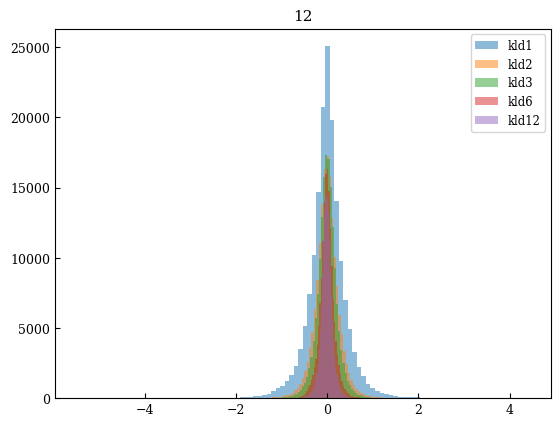

In [13]:
import matplotlib.pyplot as plt

columns = [1, 2, 3, 6, 12]

for col in columns:
    kld = pd.read_csv(f'./KLD/distributions_{col}.csv', index_col=0)
    eval(f'plt.hist(kld["Resonance_{col}"], bins=100, alpha=0.5, label="kld{col}")')
plt.legend(loc='upper right')
plt.title(col)
plt.show()




# Authors : NTR

In [14]:
w = 12

In [15]:
kld = pd.read_csv(f'./KLD/distributions_{w}.csv', index_col=0)
kld['Article Title'] = list(venues['Article Title'])
kld.reset_index(inplace=True)
kld.set_index('Article Title', inplace=True)
kld = kld[~kld.index.duplicated(keep='first')]

In [16]:
top = pd.read_csv('./database/top1000authors.csv', index_col=0)
top['Papers'] = top['Papers'].apply(lambda x: eval(x))
dups = top[top.duplicated(subset=['pids'], keep=False)].sort_values('pids')
combined_rows = pd.DataFrame(columns=top.columns)

for dup in np.unique(dups['pids']):
    duplicate_rows = dups[dups['pids'] == dup]
    combined_papers = []
    for papers in duplicate_rows['Papers']:
        combined_papers += papers
    combined_row = duplicate_rows.iloc[0].copy()
    combined_row['Papers'] = combined_papers
    combined_row.name = duplicate_rows.index[0]
    combined_rows = combined_rows.append(combined_row)

top = top.drop(dups.index)
top = top.append(combined_rows)

top['publications'] = top['Papers'].apply(lambda x: len(x))
top = top[top['publications'] > 52]

In [17]:
top['Novelties'] = [[kld.loc[paper, f'Novelty_{w}'] for paper in x] for x in top['Papers']]
top['Resonances'] = [[kld.loc[paper, f'Resonance_{w}'] for paper in x] for x in top['Papers']]

In [18]:
top['N'] = [np.nanmean(x) for x in top['Novelties']]
top['zN'] = (top['N'] - top['N'].mean()) / top['N'].std()
top['R'] = [np.nanmean(x) for x in top['Resonances']]
top['zR'] = (top['R'] - top['R'].mean()) / top['R'].std()

In [19]:
#top = top[['zN', 'zR']]
top.rename_axis('Author', inplace=True)
top.reset_index(inplace=True)
top.rename_axis('position', inplace=True)

In [20]:
x = top['zN'].values
y = top['zR'].values

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
top['y_pred'] = model.predict(x.reshape(-1, 1))
top['DzR'] = top['zR'] - top['y_pred']

In [21]:
topzN = top.sort_values('zN', ascending=False).head()['Author'].values
badzN = top.sort_values('zN', ascending=False).tail()['Author'].values
topzR = top.sort_values('zR', ascending=False).head()['Author'].values
badzR = top.sort_values('zR', ascending=False).tail()['Author'].values
topDzR = top.sort_values('DzR', ascending=False).head()['Author'].values
badDzR = top.sort_values('DzR', ascending=False).tail()['Author'].values
#print(topzN)
#print(badzN)
print(topzR)
print(topDzR)
print(badzR)
print(badDzR)

['LIANG, XIAODAN' 'PANG, YANWEI' 'QIN, TAO' 'LI, HONGSHENG' 'LU, HUCHUAN']
['LIANG, XIAODAN' 'QIN, TAO' 'HUANG, XUANJING' 'ZHAO, DONGYAN' 'WEI, FURU']
['LIAO, HUCHANG' 'SONG, QIANKUN' 'TONG, SHAOCHENG' 'XIE, XIANGPENG'
 'ZHONG, SHOUMING']
['SONG, QIANKUN' 'SZEPESVARI, CSABA' 'RAJA, MUHAMMAD ASIF ZAHOOR'
 'XIE, XIANGPENG' 'ZHONG, SHOUMING']


In [22]:
top.sort_values('zN', ascending=False, inplace=True)
top.index = range(1, len(top)+1)
top.head()

,Author,Papers,publications,pids,names,Novelties,Resonances,N,zN,R,zR,y_pred,DzR
1,"LIAO, HUCHANG",[Preference Relations Based on Intuitionistic ...,57,129/4568,"['129/4568', '129/4568', '129/4568', '129/4568...","[9.22953082176857, 9.715790442312256, 9.665884...","[-0.201617325900548, 0.0116212115203229, -0.05...",9.330571,5.666186,-0.077838,-2.653627,-1.538382,-1.115245
2,"XU, ZESHUI",[A method for multiple attribute decision maki...,162,12/1328,"['12/1328', '12/1328', '12/1328', '12/1328', '...","[8.84852045714925, 11.321152176743723, 9.85855...","[0.0831969509757151, 0.1367819298109367, 0.076...",9.316406,5.598791,-0.067162,-2.304098,-1.520085,-0.784014
3,"YAGER, RONALD R.",[Measures of specificity of fuzzy sets under T...,82,yRonaldRYager,NaN,"[8.703764724436114, 8.630127256908988, 6.96227...","[0.0228159061214476, 0.0083645481978535, -0.05...",9.088240,4.513210,-0.063374,-2.180071,-1.225347,-0.954724
4,"CHEN, SHYI-MING",[Handling forecasting problems based on two-fa...,104,11/3080,"['11/3080', '11/3080', '11/3080', '11/3080', '...","[9.250305639013543, 8.707179611009101, 9.31981...","[0.0050218944801745, -0.0139416018286251, -0.0...",9.061451,4.385753,0.003851,0.020881,-1.190742,1.211624
5,"BUSTINCE, HUMBERTO",[Construction of Interval-Valued Fuzzy Relatio...,56,68/478,"['68/478', '68/478', '68/478', '68/478', '68/4...","[8.844253911626245, 9.676965702408872, 8.67451...","[-0.1669318641771404, -0.1001957159284661, -0....",8.948540,3.848536,-0.073063,-2.497297,-1.044886,-1.452410


In [23]:
top.sort_values('zR', ascending=False, inplace=True)
top.index = range(1, len(top)+1)
top.head()

,Author,Papers,publications,pids,names,Novelties,Resonances,N,zN,R,zR,y_pred,DzR
1,"LIANG, XIAODAN",[Matching-CNN Meets KNN: Quasi-Parametric Huma...,84,136/0900,"['84/7019', '136/0900', '136/0900', '136/0900'...","[7.764975410636514, 7.869020786600875, 7.84631...","[0.016658239871476, 0.1416676122388205, 0.0572...",7.949892,-0.902894,0.099149,3.140928,0.245138,2.895790
2,"PANG, YANWEI","[Binary two-dimensional PCA, Effective Feature...",57,35/5889,"['35/5889', '35/5889', '35/5889', '35/5889', '...","[7.656661424652538, 8.388387067091527, 7.80973...","[-0.1619319852232923, -0.1292621603504482, -0....",7.862343,-1.319441,0.088821,2.802782,0.358231,2.444550
3,"QIN, TAO",[Incentivizing High-uality Content from Hetero...,65,14/6841,"['14/6841', '14/6841', '14/6841', '14/6841', '...","[8.447184495896007, 7.780762730136475, 7.67294...","[0.0400864041278428, 0.0365263636787034, -0.05...",8.386063,1.172348,0.081938,2.577443,-0.318295,2.895738
4,"LI, HONGSHENG",[Automatic Image Annotation Using Group Sparsi...,67,27/7402,"['27/7402', '27/7402', '27/7402', '27/7402', '...","[8.405473886936097, 8.632502680262325, 7.84012...","[-0.0361720796148166, -0.0674577871935167, -0....",7.936509,-0.966573,0.080483,2.529785,0.262427,2.267358
5,"LU, HUCHUAN",[Two dimensional principal components of natur...,84,64/6896,"['64/6896', '64/6896', '64/6896', '64/6896', '...","[7.841101123154554, 8.590095887268872, 8.13970...","[0.1526586805337917, 0.1601564359106539, 0.085...",7.884781,-1.212686,0.077220,2.422981,0.329247,2.093734


In [24]:
top.sort_values('zN', ascending=False, inplace=True)
top.index = range(1, len(top)+1)
top.tail()

,Author,Papers,publications,pids,names,Novelties,Resonances,N,zN,R,zR,y_pred,DzR
509,"LI, XI",[Robust visual tracking based on incremental t...,59,46/2311,"['46/2311', '46/2311', '13/8698', '46/2311', '...","[7.599299020079413, 7.303465470220132, 7.42379...","[-0.0698084452437779, -0.0547235032671649, -0....",7.769149,-1.762848,0.034443,1.022460,0.478617,0.543843
510,"QIAO, JUNFEI",[A tabu based neural network learning algorith...,75,81/516,"['81/516', '81/516', '81/516', '81/516', '81/5...","[7.937332295798314, 7.503636077403321, 8.24304...","[-0.0348670739459358, -0.1692013475482312, 0.1...",7.743465,-1.885050,-0.005328,-0.279640,0.511796,-0.791436
511,"JI, RONGRONG",[Towards Semantic Embedding in Visual Vocabula...,107,86/5681,"['86/5681', '86/5681', '86/5681', '86/5681', '...","[7.682727115326492, 7.960455706596947, 7.38753...","[-0.0042651706346275, -0.0956113475733433, -0....",7.724182,-1.976793,0.058044,1.795154,0.536704,1.258450
512,"RAJA, MUHAMMAD ASIF ZAHOOR",[Neural network optimized with evolutionary co...,69,13/7717,"['13/7717', '13/7717', '64/7139', '64/7139', '...","[7.982270673784414, 8.632665032506054, 8.00696...","[-0.0639507181781953, -0.0420986015934303, -0....",7.674761,-2.211932,-0.067140,-2.303372,0.600545,-2.903916
513,"ZHU, SC","[Region competition: Unifying snakes, region g...",164,10/10313,"['10/10313', '10/10313', '10/10313', '10/10313...","[7.569541894062773, 7.52728300472222, 7.639205...","[-0.0891730035604698, -0.1651762644515289, -0....",7.657345,-2.294795,-0.012510,-0.514803,0.623042,-1.137845


In [45]:
top.sort_values('zR', ascending=False, inplace=True)
top.index = range(1, len(top)+1)
top.tail()

,Author,Papers,publications,pids,names,Novelties,Resonances,N,zN,R,zR,y_pred,DzR
509,"LIAO, HUCHANG",[Preference Relations Based on Intuitionistic ...,57,129/4568,"['129/4568', '129/4568', '129/4568', '129/4568...","[9.22953082176857, 9.715790442312256, 9.665884...","[-0.201617325900548, 0.0116212115203229, -0.05...",9.330571,5.666186,-0.077838,-2.653627,-1.538382,-1.115245
510,"SONG, QIANKUN",[Impulsive effects on stability of fuzzy Cohen...,58,10/6543,"['10/6543', '10/6543', '10/6543', '10/6543', '...","[8.035954027109081, 8.052789064929728, 7.81134...","[-0.0851142133368298, 0.0884238480931083, -0.1...",8.345635,0.979994,-0.080255,-2.732761,-0.266071,-2.466691
511,"TONG, SHAOCHENG",[Adaptive fuzzy output tracking control of MIM...,130,83/210,"['83/210', '83/210', '83/210', '83/210', '83/2...","[8.475492840141378, 8.227173969593633, 8.65126...","[0.0010470315978388, -0.0378341191243336, 0.07...",8.635608,2.359647,-0.086040,-2.922138,-0.640650,-2.281488
512,"XIE, XIANGPENG",[Relaxed Stability Conditions for Continuous-T...,57,44/9956,"['44/9956', '44/9956', '44/9956', '44/9956', '...","[8.314562482017598, 8.144693841846715, 8.29108...","[-0.0532733451648326, -0.1071857797069615, 0.0...",8.116582,-0.109807,-0.090585,-3.070966,0.029813,-3.100779
513,"ZHONG, SHOUMING",[Global asymptotic stability analysis of nonli...,76,30/4519,"['30/4519', '30/4519', '30/4519', '30/4519', '...","[7.840922948874311, 8.533710343049494, 8.07029...","[-0.0502567708229859, -0.187029069201829, -0.1...",8.324070,0.877391,-0.101075,-3.414407,-0.238214,-3.176193


In [26]:
top.sort_values('DzR', ascending=False, inplace=True)
top.index = range(1, len(top)+1)
top.head()

,Author,Papers,publications,pids,names,Novelties,Resonances,N,zN,R,zR,y_pred,DzR
1,"LIANG, XIAODAN",[Matching-CNN Meets KNN: Quasi-Parametric Huma...,84,136/0900,"['84/7019', '136/0900', '136/0900', '136/0900'...","[7.764975410636514, 7.869020786600875, 7.84631...","[0.016658239871476, 0.1416676122388205, 0.0572...",7.949892,-0.902894,0.099149,3.140928,0.245138,2.895790
2,"QIN, TAO",[Incentivizing High-uality Content from Hetero...,65,14/6841,"['14/6841', '14/6841', '14/6841', '14/6841', '...","[8.447184495896007, 7.780762730136475, 7.67294...","[0.0400864041278428, 0.0365263636787034, -0.05...",8.386063,1.172348,0.081938,2.577443,-0.318295,2.895738
3,"HUANG, XUANJING",[QUESTION IDENTIFICATION IN CHINESE MICRO-TEXT...,69,05/6735,"['05/6735', '05/6735', '05/6735', '05/6735', '...","[8.877680460344632, 8.398488638873644, 8.05971...","[0.0442091721057646, -0.0799994511341832, 0.01...",8.440246,1.430144,0.073224,2.292139,-0.388287,2.680426
4,"ZHAO, DONGYAN",[Two-stage multiple kernel learning with multi...,65,63/1870,"['63/1870', '63/1870', '63/1870', '63/1870', '...","[8.55249360058144, 8.551085406149758, 7.940944...","[-0.0639520916238751, 0.0827890087551708, 0.01...",8.556081,1.981269,0.065559,2.041170,-0.537919,2.579089
5,"WEI, FURU",[Constrained Co-Clustering for Textual Documen...,68,72/5870,"['72/5870', '72/5870', '72/5870', '72/5870', '...","[8.581466484787326, 8.5486879672701, 9.4845982...","[-0.0475497642122331, 0.062310001701384, 0.078...",8.724937,2.784665,0.056357,1.739898,-0.756043,2.495941


In [27]:
top.sort_values('DzR', ascending=False, inplace=True)
top.index = range(1, len(top)+1)
top.tail()

,Author,Papers,publications,pids,names,Novelties,Resonances,N,zN,R,zR,y_pred,DzR
509,"SONG, QIANKUN",[Impulsive effects on stability of fuzzy Cohen...,58,10/6543,"['10/6543', '10/6543', '10/6543', '10/6543', '...","[8.035954027109081, 8.052789064929728, 7.81134...","[-0.0851142133368298, 0.0884238480931083, -0.1...",8.345635,0.979994,-0.080255,-2.732761,-0.266071,-2.466691
510,"SZEPESVARI, CSABA","[Continuous Time Associative Bandit Problems, ...",67,62/567,"['62/567', '62/567', '62/567', '62/567', '62/5...","[7.832964968008624, 7.634639390331241, 7.35425...","[-0.155362935925102, -0.1507531126586787, -0.1...",8.063970,-0.360127,-0.070209,-2.403854,0.097775,-2.501630
511,"RAJA, MUHAMMAD ASIF ZAHOOR",[Neural network optimized with evolutionary co...,69,13/7717,"['13/7717', '13/7717', '64/7139', '64/7139', '...","[7.982270673784414, 8.632665032506054, 8.00696...","[-0.0639507181781953, -0.0420986015934303, -0....",7.674761,-2.211932,-0.067140,-2.303372,0.600545,-2.903916
512,"XIE, XIANGPENG",[Relaxed Stability Conditions for Continuous-T...,57,44/9956,"['44/9956', '44/9956', '44/9956', '44/9956', '...","[8.314562482017598, 8.144693841846715, 8.29108...","[-0.0532733451648326, -0.1071857797069615, 0.0...",8.116582,-0.109807,-0.090585,-3.070966,0.029813,-3.100779
513,"ZHONG, SHOUMING",[Global asymptotic stability analysis of nonli...,76,30/4519,"['30/4519', '30/4519', '30/4519', '30/4519', '...","[7.840922948874311, 8.533710343049494, 8.07029...","[-0.0502567708229859, -0.187029069201829, -0.1...",8.324070,0.877391,-0.101075,-3.414407,-0.238214,-3.176193


# Venues : NTR

In [28]:
ven = pd.DataFrame()
ven['N'] =  venues.groupby('Venue').apply(lambda x: kld.loc[x['Article Title'], f'Novelty_{w}'].mean())
ven['zN'] = (ven['N'] - ven['N'].mean()) / ven['N'].std()
ven['R'] =  venues.groupby('Venue').apply(lambda x: kld.loc[x['Article Title'], f'Resonance_{w}'].mean())
ven['zR'] = (ven['R'] - ven['R'].mean()) / ven['R'].std()

x = ven['zN'].values
y = ven['zR'].values

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
ven['y_pred'] = model.predict(x.reshape(-1, 1))
ven['DzR'] = ven['zR'] - ven['y_pred']
ven.sort_values('DzR', ascending=False)

,N,zN,R,zR,y_pred,DzR
Venue,,,,,,
ICLR,8.030215,-0.122630,0.039648,2.586668,-0.019729,2.606397
ACL,8.486799,2.541171,0.037346,2.477051,0.408832,2.068220
ICCV,8.000232,-0.297556,0.020562,1.678040,-0.047872,1.725911
AAAI,8.148322,0.566430,0.004349,0.906168,0.091129,0.815038
IEEE-TNNLS,7.976021,-0.438810,-0.008165,0.310409,-0.070597,0.381007
NIPS,7.943871,-0.626380,-0.013268,0.067488,-0.100774,0.168262
Neurocomputing,7.952626,-0.575297,-0.013513,0.055825,-0.092556,0.148381
JMLR,7.972395,-0.459965,-0.013299,0.065990,-0.074001,0.139991
ICML,8.033140,-0.105567,-0.012229,0.116920,-0.016984,0.133904


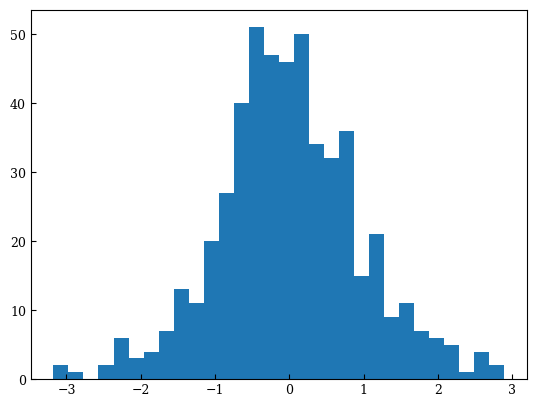

In [39]:
# histogram of ven['DzR']
plt.hist(top['DzR'], bins=30)
plt.show()

In [41]:
top['DzR'].std()

0.9624377879373983